In [1]:
"""
Solution for the Burgers equation solution with MPDATA
"""
from functools import partial

import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import root_scalar

from open_atmos_jupyter_utils import show_plot, show_anim

from PyMPDATA import Options, Solver, Stepper, VectorField, ScalarField
from PyMPDATA.boundary_conditions import Constant

OPTIONS = Options(nonoscillatory=False, infinite_gauge=True)
T_MAX = 1
T_SHOCK = 1 / np.pi
T_RANGE = [0, 0.1, 0.3, 0.5, 0.7, 1]

NT = 400
NX = 100

X_ANAL = np.linspace(-1, 1, NX)

In [2]:
def f(x0, t, xi):
    """
    The function to solve: x0 - sin(pi*x0)*t - xi = 0
    where xi is the initial condition at x0.
    """
    return x0 - np.sin(np.pi*x0)*t - xi

def df(x0, t, _):
    """
    The derivative of the function f with respect to x0.
    """
    return 1 - np.cos(np.pi*x0)*np.pi*t

In [3]:
def find_root(x0, t, xi):
    """Find the root of the equation f(x0, t, xi) = 0 using Newton's method."""
    return root_scalar(f, args=(t, xi), x0=x0, method='newton', maxiter=1000, fprime=df).root

In [4]:
def analytical_solution(x, t):
    """
    Analytical solution for the wave equation
    """
    u = np.zeros(len(x))
    for i, xi in enumerate(x):
        if t < T_SHOCK:
            x0 = find_root(x0=0, t=t, xi=xi)
            u[i] = -np.sin(np.pi * x0)
        else:
            if xi == 0:
                u[i] = 0
            else:
                x0 = find_root(x0=xi/abs(xi), t=t, xi=xi)
                u[i] = -np.sin(np.pi * x0)
    return u

In [5]:
def initialize_simulation(nt, nx, t_max):
    """
    Initializes simulation variables and returns them.
    """
    dt = t_max / nt
    courants_x, dx = np.linspace(-1, 1, nx + 1, endpoint=True, retstep=True)
    x = courants_x[:-1] + dx / 2
    u0 = -np.sin(np.pi * x)

    stepper = Stepper(options=OPTIONS, n_dims=1)
    advectee = ScalarField(
        data=u0,
        halo=OPTIONS.n_halo,
        boundary_conditions=(Constant(0), Constant(0))
    )
    advector = VectorField(
        data=(np.full(courants_x.shape, 0.0),),
        halo=OPTIONS.n_halo,
        boundary_conditions=(Constant(0), Constant(0))
    )
    solver = Solver(stepper=stepper, advectee=advectee, advector=advector)
    return dt, dx, x, advectee, advector, solver

In [6]:
def update_advector_n(vel, dt, dx, slice_idx):
    """
    Computes and returns the updated advector_n.
    """
    indices = np.arange(slice_idx.start, slice_idx.stop)
    return 0.5 * ((vel[indices] - vel[indices - 1]) / 2 + vel[:-1]) * dt / dx

In [7]:
def calculate_analytical_solutions():
    """
    Calculate the analytical solutions for the given time range.
    """
    solutions = np.zeros((len(X_ANAL), len(T_RANGE)))

    for j, t in enumerate(T_RANGE):
        solutions[:, j] = analytical_solution(X_ANAL, t)

    return solutions

In [8]:
def run_numerical_simulation(nt=400, nx=100, t_max=1):
    """
    Runs the numerical simulation and returns (states, x, dt, dx).
    """
    dt, dx, x, advectee, advector, solver = initialize_simulation(nt, nx, t_max)
    states = []
    vel = advectee.get()
    advector_n_1 = 0.5 * (vel[:-1] + np.diff(vel) / 2) * dt / dx
    assert np.all(advector_n_1 <= 1)
    i = slice(1, len(vel))

    for _ in range(nt):
        vel = advectee.get()
        advector_n = update_advector_n(vel, dt, dx, i)
        advector.get_component(0)[1:-1] = 0.5 * (3 * advector_n - advector_n_1)
        assert np.all(advector.get_component(0) <= 1)

        solver.advance(n_steps=1)
        advector_n_1 = advector_n.copy()
        states.append(solver.advectee.get().copy())

    return np.array(states), x, dt, dx

In [9]:
def plot_analytical_solutions(solutions, t_range, figsize=(5, 5)):
    """
    Plots the analytical solution of the Burgers' equation.

    Parameters:
        x (list or np.ndarray): The x-coordinates.
        solutions (list or np.ndarray): The solutions corresponding to each t in t_range.
        t_range (list): The time points corresponding to the solutions.
        filename (str): The name of the file to save the plot. Default is "analytical".
        figsize (tuple): The figure size. Default is (5, 5).

    Returns:
        None
    """
    fig = plt.figure(figsize=figsize)
    plt.plot(X_ANAL, solutions)
    plt.xlabel('x')
    plt.ylabel('u')
    plt.xlim([-1, 1])
    plt.ylim([-1, 1])
    plt.title('Analytical Burgers Equation Solution')
    plt.legend([f"t={t}" for t in t_range])
    plt.grid(True)
    show_plot(fig=fig, filename="analytical")


def plot_numerical_vs_analytical(states, x, t, t_max, nt):
    """
    Plots the numerical solution at time t alongside the analytical solution.
    """
    analytical = analytical_solution(x, t)

    # Calculate the time index based on t, t_max, and nt
    time_index = int((t / t_max) * nt)
    # Make sure it doesn't exceed available indices
    time_index = min(time_index, len(states) - 1)

    # Extract the numerical solution at this time step
    numerical = states[time_index, :]

    plt.figure(figsize=(8, 5))
    plt.plot(x, numerical, label='Numerical')
    plt.plot(x, analytical, label='Analytical', linestyle='--')
    plt.xlabel("x")
    plt.ylabel("Advectee")
    plt.title(f"1D Advection with PyMPDATA at t={t:.3f}")
    plt.grid(True)
    plt.legend()
    plt.show()


def plot_gif(step, states, x, dt):
    """
    Plots the numerical solution at a specific step alongside the analytical solution.
    """
    fig = plt.figure()
    plt.plot(x, analytical_solution(x, 0), label='Start')
    plt.plot(x, states[step], label='Numerical')
    plt.step(x, analytical_solution(x, step * dt), label='Analytical')
    plt.xlabel("x")
    plt.ylabel("Advectee")
    plt.title(f"1D Advection with PyMPDATA for time={step * dt:.3f}")
    plt.grid()
    plt.legend()
    return fig

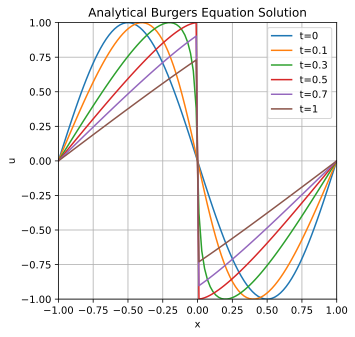

In [10]:
analytical_solutions = calculate_analytical_solutions()
plot_analytical_solutions(analytical_solutions, T_RANGE)

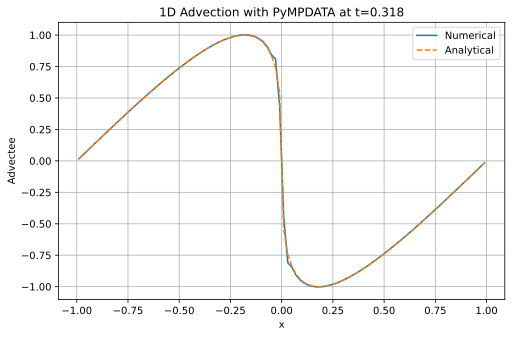

In [11]:
states_num, x_num, dt_num, dx_num = run_numerical_simulation(nt=NT, nx=NX, t_max=T_MAX)
plot_numerical_vs_analytical(states_num, x_num, T_SHOCK, T_MAX, NT)
plot_partial = partial(plot_gif, states=states_num, x=x_num, dt=dt_num)


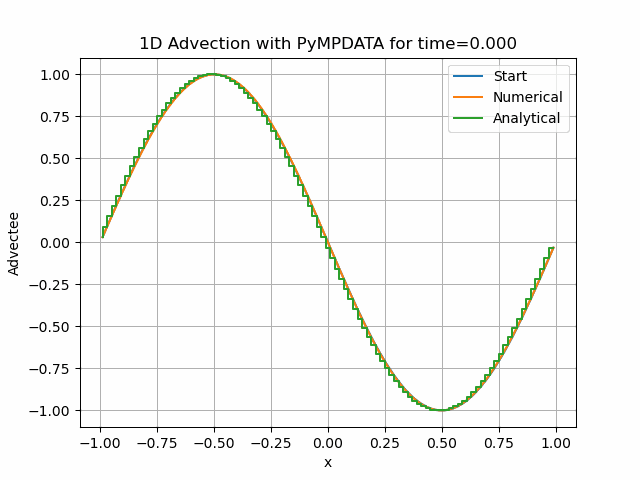

HTML(value="<a href='./numerical.gif' target='_blank'>./numerical.gif</a><br>")

In [12]:
show_anim(plot_partial, range(0, int(T_SHOCK/(T_MAX/NT))), gif_file="numerical.gif")